# Rigorous EDA for ds003029 (iEEG/ECoG/SEEG) — Seizure Detection Readiness

**Goal:** Build a rigorous Exploratory Data Analysis (EDA) report that evaluates whether ds003029 is suitable for seizure detection modeling and what preprocessing is required.

**Scope constraints (enforced):**
- EDA only (no model training, no classifier evaluation).
- Seizure detection as **binary** labeling (ictal vs non-ictal) using onset/offset metadata.
- Window-based analysis is used **only** to inspect signal properties (non-stationarity, outliers, label alignment).

**Data reality check:** In this workspace, usable signal availability is limited (only a subset of runs have annex content). This notebook makes that limitation explicit and treats all conclusions as conditional on the current downloaded subset.

## 0) Setup: paths, reproducibility, and safety

This section defines paths and analysis parameters. Keep heavy computations bounded (few runs, short excerpts).

In [14]:
from __future__ import annotations

from pathlib import Path
import math
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

try:
    import mne
except Exception as e:
    mne = None
    print('WARNING: mne is not available. Signal-level EDA cells will fail until mne is installed. Error:', e)

try:
    from scipy.signal import welch
except Exception as e:
    welch = None
    print('WARNING: scipy is not available. PSD/bandpower cells will fail until scipy is installed. Error:', e)

plt.rcParams['figure.figsize'] = (10, 4)
pd.set_option('display.max_columns', 200)
np.random.seed(0)

DATASET_ROOT = Path('EEG') / 'ds003029'
RUN_SUMMARY_CSV = Path('eda_outputs') / 'ds003029_run_summary.csv'

# Analysis knobs (keep light for EDA)
N_RUNS_DEEP = 3              # deep signal inspection
MAX_CHANNELS = 16            # cap channels for fast EDA
PRE_SEC = 120                # seconds before onset (if available)
POST_SEC = 120               # seconds after offset (if available)
EXCERPT_PSD_SEC = 10         # short excerpt for PSD
WINDOW_SEC = 2.0
STEP_SEC = 1.0

print('DATASET_ROOT:', DATASET_ROOT.resolve())
print('RUN_SUMMARY_CSV:', RUN_SUMMARY_CSV.resolve())

DATASET_ROOT: C:\Users\LENOVO\Downloads\eeg\EEG\ds003029
RUN_SUMMARY_CSV: C:\Users\LENOVO\Downloads\eeg\eda_outputs\ds003029_run_summary.csv


## 1) Dataset overview and coverage

**EDA questions answered here:**
1. How many subjects and runs exist in metadata?
2. What fraction of runs have downloadable signal content?
3. How many runs have seizure onset/offset?
4. How are sampling rate, channel count, recording duration, and seizure duration distributed?

**Why this matters:** If only a small subset of runs has signal content, any conclusions about modeling/generalization must be stated as *limited to that subset*.

In [15]:
assert RUN_SUMMARY_CSV.exists(), f'Missing {RUN_SUMMARY_CSV}. Generate it first.'
run_summary = pd.read_csv(RUN_SUMMARY_CSV)
print('run_summary shape:', run_summary.shape)
display(run_summary.head())

# Expected columns (based on prior pipeline)
expected = [
    'subject','base','acq','run',
    'has_onset','has_offset','seizure_onset_s','seizure_offset_s',
    'sfreq','n_channels','duration_s','seizure_duration_s'
]
missing = [c for c in expected if c not in run_summary.columns]
print('Missing expected columns:', missing)

# Identify an 'EEG content present' indicator
eeg_present_col = None
for c in ['eeg_content_present','ieeg_content_present','signal_present']:
    if c in run_summary.columns:
        eeg_present_col = c
        break
print('Using eeg-present column:', eeg_present_col)

n_total = len(run_summary)
n_subjects = run_summary['subject'].nunique() if 'subject' in run_summary.columns else np.nan
n_with_eeg = int(run_summary[eeg_present_col].fillna(0).astype(int).sum()) if eeg_present_col else 0
n_with_onoff = int(((run_summary.get('has_onset',0)==1) & (run_summary.get('has_offset',0)==1)).sum())
n_with_onoff_and_eeg = int((((run_summary.get('has_onset',0)==1) & (run_summary.get('has_offset',0)==1)) & (run_summary[eeg_present_col].fillna(0).astype(int)==1)).sum()) if eeg_present_col else 0

print(f'Subjects (metadata): {n_subjects}')
print(f'Runs (metadata): {n_total}')
print(f'Runs with EEG content: {n_with_eeg} / {n_total}  ({n_with_eeg/max(n_total,1):.1%})')
print(f'Runs with onset+offset: {n_with_onoff} / {n_total}  ({n_with_onoff/max(n_total,1):.1%})')
print(f'Runs with onset+offset+EEG: {n_with_onoff_and_eeg} / {n_total}  ({n_with_onoff_and_eeg/max(n_total,1):.1%})')

run_summary shape: (106, 28)


,subject,session,task,acq,run,suffix,base,events_tsv,channels_tsv,ieeg_json,vhdr,vmrk,eeg,n_channels,n_good,n_bad,type_counts,sfreq,line_freq,has_onset,has_offset,seizure_onset_s,seizure_offset_s,seizure_duration_s,eeg_worktree_exists,eeg_content_present,eeg_present,eeg_size_bytes
0,jh101,presurgery,ictal,ecog,1,ieeg,EEG\ds003029\sub-jh101\ses-presurgery\ieeg\sub...,EEG\ds003029\sub-jh101\ses-presurgery\ieeg\sub...,EEG\ds003029\sub-jh101\ses-presurgery\ieeg\sub...,EEG\ds003029\sub-jh101\ses-presurgery\ieeg\sub...,EEG\ds003029\sub-jh101\ses-presurgery\ieeg\sub...,EEG\ds003029\sub-jh101\ses-presurgery\ieeg\sub...,EEG\ds003029\sub-jh101\ses-presurgery\ieeg\sub...,135,109,26,"{'ECOG': 126, 'MISC': 9}",1000.0,60,True,True,58.950,79.875,20.925,True,True,True,76788000
1,jh101,presurgery,ictal,ecog,2,ieeg,EEG\ds003029\sub-jh101\ses-presurgery\ieeg\sub...,EEG\ds003029\sub-jh101\ses-presurgery\ieeg\sub...,EEG\ds003029\sub-jh101\ses-presurgery\ieeg\sub...,EEG\ds003029\sub-jh101\ses-presurgery\ieeg\sub...,EEG\ds003029\sub-jh101\ses-presurgery\ieeg\sub...,EEG\ds003029\sub-jh101\ses-presurgery\ieeg\sub...,EEG\ds003029\sub-jh101\ses-presurgery\ieeg\sub...,135,109,26,"{'ECOG': 126, 'MISC': 9}",1000.0,60,True,True,66.825,275.850,209.025,True,True,True,182614500
2,jh101,presurgery,ictal,ecog,3,ieeg,EEG\ds003029\sub-jh101\ses-presurgery\ieeg\sub...,EEG\ds003029\sub-jh101\ses-presurgery\ieeg\sub...,EEG\ds003029\sub-jh101\ses-presurgery\ieeg\sub...,EEG\ds003029\sub-jh101\ses-presurgery\ieeg\sub...,EEG\ds003029\sub-jh101\ses-presurgery\ieeg\sub...,EEG\ds003029\sub-jh101\ses-presurgery\ieeg\sub...,EEG\ds003029\sub-jh101\ses-presurgery\ieeg\sub...,135,109,26,"{'ECOG': 126, 'MISC': 9}",1000.0,60,True,True,58.950,79.875,20.925,True,True,True,76788000
3,jh101,presurgery,ictal,ecog,4,ieeg,EEG\ds003029\sub-jh101\ses-presurgery\ieeg\sub...,EEG\ds003029\sub-jh101\ses-presurgery\ieeg\sub...,EEG\ds003029\sub-jh101\ses-presurgery\ieeg\sub...,EEG\ds003029\sub-jh101\ses-presurgery\ieeg\sub...,EEG\ds003029\sub-jh101\ses-presurgery\ieeg\sub...,EEG\ds003029\sub-jh101\ses-presurgery\ieeg\sub...,EEG\ds003029\sub-jh101\ses-presurgery\ieeg\sub...,135,109,26,"{'ECOG': 126, 'MISC': 9}",1000.0,60,True,True,58.950,84.825,25.875,True,False,False,69
4,jh102,presurgery,ictal,ecog,1,ieeg,EEG\ds003029\sub-jh102\ses-presurgery\ieeg\sub...,EEG\ds003029\sub-jh102\ses-presurgery\ieeg\sub...,EEG\ds003029\sub-jh102\ses-presurgery\ieeg\sub...,EEG\ds003029\sub-jh102\ses-presurgery\ieeg\sub...,EEG\ds003029\sub-jh102\ses-presurgery\ieeg\sub...,EEG\ds003029\sub-jh102\ses-presurgery\ieeg\sub...,EEG\ds003029\sub-jh102\ses-presurgery\ieeg\sub...,123,115,8,"{'ECOG': 115, 'MISC': 8}",1000.0,60,True,True,54.834,333.944,279.110,True,True,True,189942012


Missing expected columns: ['duration_s']
Using eeg-present column: eeg_content_present
Subjects (metadata): 35
Runs (metadata): 106
Runs with EEG content: 16 / 106  (15.1%)
Runs with onset+offset: 73 / 106  (68.9%)
Runs with onset+offset+EEG: 16 / 106  (15.1%)


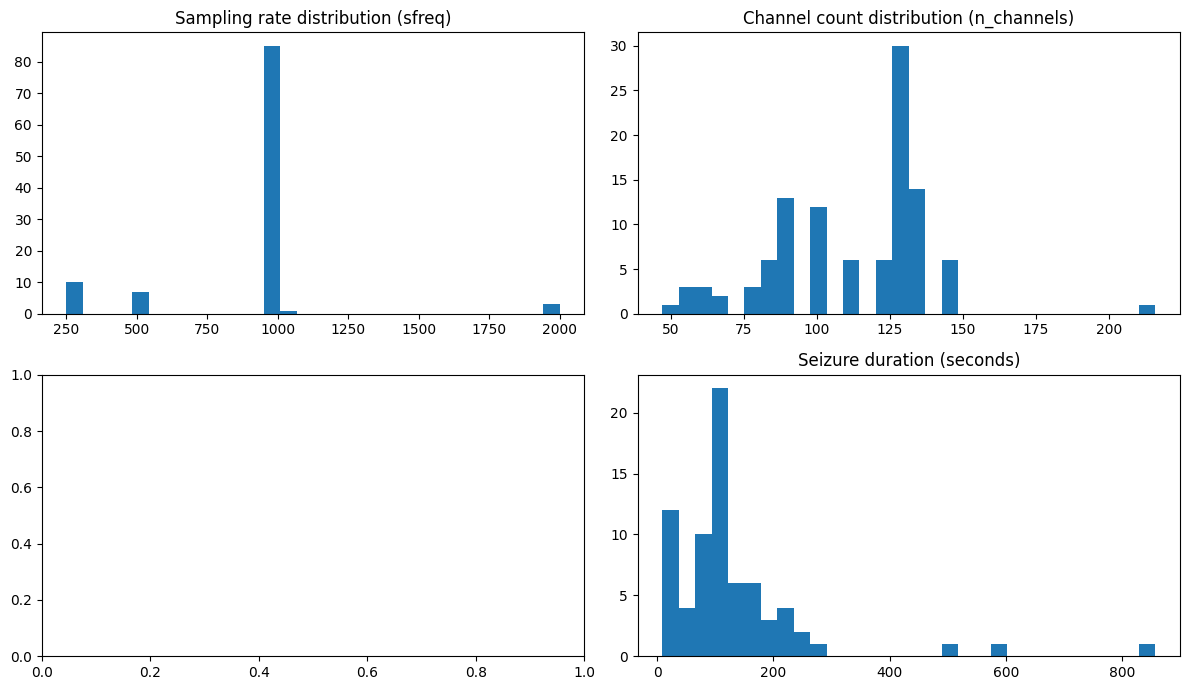

In [16]:
# Distribution plots (metadata-level)
fig, axes = plt.subplots(2, 2, figsize=(12, 7))
axes = axes.ravel()

if 'sfreq' in run_summary.columns:
    axes[0].hist(run_summary['sfreq'].dropna(), bins=30)
    axes[0].set_title('Sampling rate distribution (sfreq)')

if 'n_channels' in run_summary.columns:
    axes[1].hist(run_summary['n_channels'].dropna(), bins=30)
    axes[1].set_title('Channel count distribution (n_channels)')

if 'duration_s' in run_summary.columns:
    axes[2].hist(run_summary['duration_s'].dropna(), bins=30)
    axes[2].set_title('Recording duration (seconds)')

if 'seizure_duration_s' in run_summary.columns:
    axes[3].hist(run_summary['seizure_duration_s'].dropna(), bins=30)
    axes[3].set_title('Seizure duration (seconds)')

plt.tight_layout()
plt.show()

### Conclusions to write (Section 1)
- Report the **usable fraction**: `runs_with_onset_offset_and_EEG / total_runs`.
- State that limited availability reduces confidence in **generalization** across subjects/acquisitions.
- Note heterogeneity (multiple `sfreq` modes, wide channel counts), which motivates standardization before any modeling.

## 2) Domain formulation and labeling logic

**EDA questions answered here:**
- What exactly is the input/output for seizure detection in this project?
- How are window labels computed from onset/offset?
- What are sources of label uncertainty?

**Core definitions:**
- Input window: $X_w n athbb{R}^{C 	imes T}$, with $T = f_s dot 	ext{windowsec}$.
- Output label: $y_w n 0,1$ where 1 = ictal if the window overlaps `[onset, offset]`.

**Important:** This notebook assumes onset/offset metadata are correct *but explicitly audits the risk that they are not*.

In [17]:
def window_label(t_start: float, t_end: float, onset: float, offset: float) -> int:
    """Binary overlap labeling: 1 if [t_start,t_end] intersects [onset,offset]."""
    if np.isnan(onset) or np.isnan(offset):
        return 0
    return int(max(t_start, onset) < min(t_end, offset))

# Demonstrate labeling logic on a toy example
onset, offset = 10.0, 20.0
examples = [(0,2), (9,11), (10,12), (19,21), (20,22)]
for a,b in examples:
    print((a,b), '->', window_label(a,b,onset,offset))

(0, 2) -> 0
(9, 11) -> 1
(10, 12) -> 1
(19, 21) -> 1
(20, 22) -> 0


### Label uncertainty (write-up guidance)
Discuss these risks explicitly:
- Onset/offset are derived from metadata (e.g., BIDS events). Errors propagate into labels.
- Timing alignment: if onset/offset are in different time bases, window labels can be shifted.
- Ambiguous peri-ictal periods: pre-ictal/post-ictal boundaries are not represented in binary labeling.

**Suggested audit:** randomly select 3–5 runs and compare `run_summary` onset/offset against raw `*_events.tsv`.

## 3) Signal amplitude and channel-level quality (Scale & artifacts)

**EDA questions answered here:**
- Are there channels with unusually high amplitude (potential artifacts/electrode issues)?
- Are there flat or near-zero channels (disconnected/dead)?
- Do we need channel rejection and/or normalization?

We use simple robust statistics: RMS and peak-to-peak (PTP) per channel, computed on a bounded excerpt.

In [18]:
from typing import Optional, List, Dict

WORKSPACE_ROOT = Path('.').resolve()
DS_PREFIX = 'EEG/ds003029/'


def _to_posix_rel(p: str) -> str:
    s = str(p).replace('\\', '/')
    while s.startswith('./'):
        s = s[2:]
    return s.lstrip('/')


def bids_sidecar_from_base(base: str, kind: str) -> str:
    """Return BIDS sidecar path (relative) by replacing the _ieeg entity.

    kind: 'events' | 'channels' | 'ieeg_json'
    """
    base = _to_posix_rel(base)
    if kind == 'events':
        if '_ieeg' in base:
            return base.replace('_ieeg', '_events') + '.tsv'
        return base + '_events.tsv'
    if kind == 'channels':
        if '_ieeg' in base:
            return base.replace('_ieeg', '_channels') + '.tsv'
        return base + '_channels.tsv'
    if kind == 'ieeg_json':
        if base.endswith('.json'):
            return base
        if base.endswith('_ieeg'):
            return base + '.json'
        return base + '_ieeg.json'
    raise ValueError(f'Unknown kind: {kind}')


def _resolve_rel_path(dataset_root: Path, rel: str) -> Path:
    """Resolve a path that might already include the 'EEG/ds003029' prefix.

    The run summary stores paths like 'EEG/ds003029/...'. If we also set
    DATASET_ROOT='EEG/ds003029', a naive join duplicates the prefix. This helper
    prevents 'EEG/ds003029/EEG/ds003029/...'.
    """
    rel_s = _to_posix_rel(rel)
    if rel_s.startswith(DS_PREFIX):
        return WORKSPACE_ROOT / rel_s
    return dataset_root / rel_s


def paths_from_base(dataset_root: Path, base: str) -> Dict[str, Path]:
    """Map a run `base` (relative path without BrainVision extension) to BIDS files.

    Assumption (aligned with ds003029 BIDS):
    - `base` points to the iEEG recording stem ending with `_ieeg`
      e.g., sub-xxx/ses-yyy/ieeg/sub-xxx_ses-yyy_task-..._acq-..._run-1_ieeg
    """
    base = _to_posix_rel(base)
    stem = _resolve_rel_path(dataset_root, base)
    return {
        'vhdr': stem.with_suffix('.vhdr'),
        'vmrk': stem.with_suffix('.vmrk'),
        'eeg': stem.with_suffix('.eeg'),
        'events': _resolve_rel_path(dataset_root, bids_sidecar_from_base(base, 'events')),
        'channels': _resolve_rel_path(dataset_root, bids_sidecar_from_base(base, 'channels')),
    }


def read_tsv_if_exists(path: Path) -> Optional[pd.DataFrame]:
    if path.exists():
        try:
            return pd.read_csv(path, sep='\t')
        except Exception as e:
            print('WARNING: failed to read', path, '->', e)
            return None
    return None


def pick_good_ieeg_channels(ch_df: Optional[pd.DataFrame], max_channels: int) -> List[str]:
    """Pick up to `max_channels` channel names that are likely valid intracranial channels.

    Uses BIDS *_channels.tsv if available (status/type). Falls back to empty list.
    """
    if ch_df is None or ch_df.empty:
        return []
    for col in ['name', 'status', 'type']:
        if col not in ch_df.columns:
            return []
    tmp = ch_df.copy()
    tmp['status'] = tmp['status'].astype(str).str.lower()
    tmp['type'] = tmp['type'].astype(str).str.upper()
    good = tmp[(tmp['status'] == 'good') & (tmp['type'].isin(['ECOG', 'SEEG']))]
    names = good['name'].astype(str).tolist()
    return names[:max_channels]


def pick_deep_runs(df: pd.DataFrame) -> pd.DataFrame:
    """Select runs for deep signal-level inspection (aligned with local availability)."""
    if eeg_present_col is None:
        raise RuntimeError('Cannot select deep runs: missing eeg_present_col in run_summary')
    available = df[df[eeg_present_col].fillna(0).astype(int) == 1].copy()
    print(f'Runs with EEG content available locally: {len(available)}')
    if len(available) == 0:
        print('WARNING: No runs marked as EEG-present; falling back to metadata-only selection')
        available = df.copy()
    has_onoff = ((available.get('has_onset', 0) == 1) & (available.get('has_offset', 0) == 1)).astype(int)
    score = 10 * has_onoff
    out = available.copy()
    out['_priority'] = score
    out = out.sort_values(['_priority'], ascending=False)
    return out.head(N_RUNS_DEEP)


deep_runs = pick_deep_runs(run_summary)
cols = ['subject','acq','run','base',eeg_present_col,'has_onset','has_offset','seizure_onset_s','seizure_offset_s','sfreq','n_channels']
cols = [c for c in cols if c in deep_runs.columns]
display(deep_runs[cols])

print('\nPath sanity check (first 3 deep runs):')
for _, r in deep_runs.head(3).iterrows():
    b = r['base']
    p = paths_from_base(DATASET_ROOT, b)
    print('base =', b)
    print('  vhdr ->', p['vhdr'], '| exists =', p['vhdr'].exists())

Runs with EEG content available locally: 16


,subject,acq,run,base,eeg_content_present,has_onset,has_offset,seizure_onset_s,seizure_offset_s,sfreq,n_channels
0,jh101,ecog,1,EEG\ds003029\sub-jh101\ses-presurgery\ieeg\sub...,True,True,True,58.950,79.875,1000.0,135
1,jh101,ecog,2,EEG\ds003029\sub-jh101\ses-presurgery\ieeg\sub...,True,True,True,66.825,275.850,1000.0,135
2,jh101,ecog,3,EEG\ds003029\sub-jh101\ses-presurgery\ieeg\sub...,True,True,True,58.950,79.875,1000.0,135



Path sanity check (first 3 deep runs):
base = EEG\ds003029\sub-jh101\ses-presurgery\ieeg\sub-jh101_ses-presurgery_task-ictal_acq-ecog_run-01_ieeg
  vhdr -> C:\Users\LENOVO\Downloads\eeg\EEG\ds003029\sub-jh101\ses-presurgery\ieeg\sub-jh101_ses-presurgery_task-ictal_acq-ecog_run-01_ieeg.vhdr | exists = True
base = EEG\ds003029\sub-jh101\ses-presurgery\ieeg\sub-jh101_ses-presurgery_task-ictal_acq-ecog_run-02_ieeg
  vhdr -> C:\Users\LENOVO\Downloads\eeg\EEG\ds003029\sub-jh101\ses-presurgery\ieeg\sub-jh101_ses-presurgery_task-ictal_acq-ecog_run-02_ieeg.vhdr | exists = True
base = EEG\ds003029\sub-jh101\ses-presurgery\ieeg\sub-jh101_ses-presurgery_task-ictal_acq-ecog_run-03_ieeg
  vhdr -> C:\Users\LENOVO\Downloads\eeg\EEG\ds003029\sub-jh101\ses-presurgery\ieeg\sub-jh101_ses-presurgery_task-ictal_acq-ecog_run-03_ieeg.vhdr | exists = True


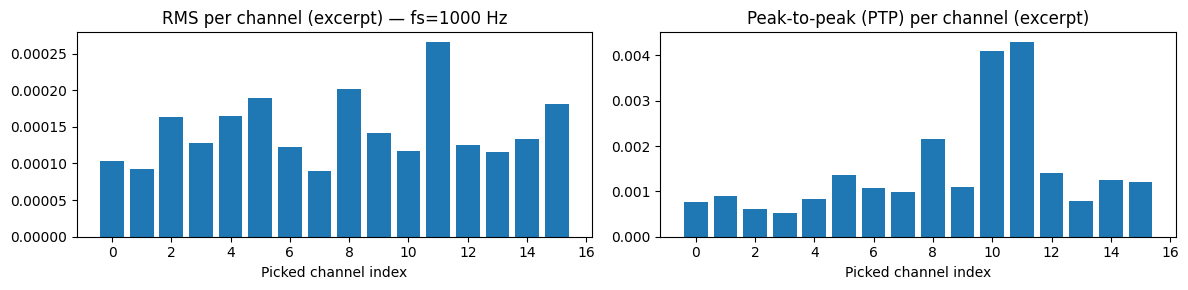

Run EEG\ds003029\sub-jh101\ses-presurgery\ieeg\sub-jh101_ses-presurgery_task-ictal_acq-ecog_run-01_ieeg: picked=16 channels; suspicious picked-channel indices (robust z>5): [10, 11]


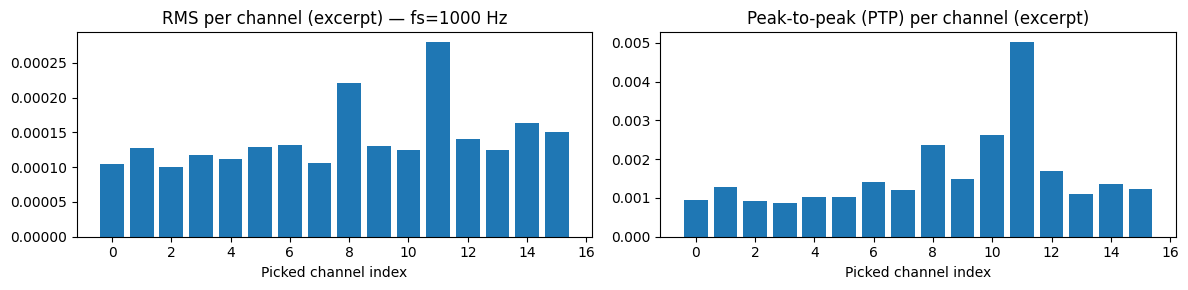

Run EEG\ds003029\sub-jh101\ses-presurgery\ieeg\sub-jh101_ses-presurgery_task-ictal_acq-ecog_run-02_ieeg: picked=16 channels; suspicious picked-channel indices (robust z>5): [11]


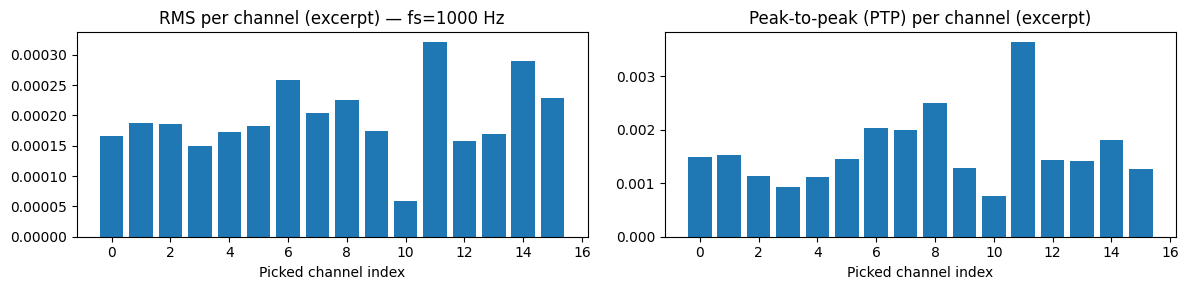

Run EEG\ds003029\sub-jh101\ses-presurgery\ieeg\sub-jh101_ses-presurgery_task-ictal_acq-ecog_run-03_ieeg: picked=16 channels; suspicious picked-channel indices (robust z>5): []


In [19]:
def rms_per_channel(x: np.ndarray) -> np.ndarray:
    return np.sqrt(np.mean(x**2, axis=1))


def ptp_per_channel(x: np.ndarray) -> np.ndarray:
    return np.ptp(x, axis=1)


def robust_z(x: np.ndarray) -> np.ndarray:
    med = np.median(x)
    mad = np.median(np.abs(x - med)) + 1e-12
    return 0.6745 * (x - med) / mad


if mne is None:
    print('Skip: mne not available')
else:
    for _, row in deep_runs.iterrows():
        base = row['base']
        p = paths_from_base(DATASET_ROOT, base)
        if not Path(p['vhdr']).exists():
            print('Missing vhdr:', p['vhdr'])
            continue

        onset = float(row.get('seizure_onset_s', np.nan))
        offset = float(row.get('seizure_offset_s', np.nan))

        raw = mne.io.read_raw_brainvision(str(p['vhdr']), preload=False, verbose='ERROR')
        fs = float(raw.info['sfreq'])

        # Define an excerpt window (bounded for EDA)
        if (not np.isnan(onset)) and (not np.isnan(offset)):
            t0 = max(0.0, onset - PRE_SEC)
            t1 = min(raw.times[-1], offset + POST_SEC)
        else:
            t0 = 0.0
            t1 = min(raw.times[-1], 5 * 60.0)

        raw_seg = raw.copy().crop(tmin=t0, tmax=t1)

        # Channel selection aligned with notebook cũ: use *_channels.tsv when available
        ch_df = read_tsv_if_exists(p['channels'])
        good_names = pick_good_ieeg_channels(ch_df, MAX_CHANNELS)
        if good_names:
            picks = mne.pick_channels(raw_seg.ch_names, include=good_names)
        else:
            # fallback: first MAX_CHANNELS channels
            picks = np.arange(min(MAX_CHANNELS, raw_seg.info['nchan']))

        x, _ = raw_seg[picks, :]

        rms = rms_per_channel(x)
        ptp = ptp_per_channel(x)

        fig, axes = plt.subplots(1, 2, figsize=(12, 3))
        axes[0].bar(np.arange(len(rms)), rms)
        axes[0].set_title(f'RMS per channel (excerpt) — fs={fs:.0f} Hz')
        axes[0].set_xlabel('Picked channel index')

        axes[1].bar(np.arange(len(ptp)), ptp)
        axes[1].set_title('Peak-to-peak (PTP) per channel (excerpt)')
        axes[1].set_xlabel('Picked channel index')
        plt.tight_layout()
        plt.show()

        # Flag suspicious channels (simple, explainable)
        z_rms = robust_z(rms)
        z_ptp = robust_z(ptp)
        suspicious = np.where((np.abs(z_rms) > 5) | (np.abs(z_ptp) > 5))[0]
        print(f'Run {base}: picked={len(picks)} channels; suspicious picked-channel indices (robust z>5):', suspicious.tolist())

### Conclusions to write (Section 3)
- If channels show extreme RMS/PTP outliers, interpret as **possible artifacts/electrode issues**.
- Justify why **channel rejection** (flatline/outlier) and **amplitude normalization** (per-run or per-channel) are required before modeling.
- Emphasize that models can otherwise learn amplitude scale rather than seizure dynamics.

## 4) Spectral characteristics and cyclical components

**EDA questions answered here:**
- What does the PSD look like (1/f structure, oscillatory activity)?
- Is there clear **line noise** (50/60 Hz) and harmonics?
- How do bandpowers distribute across frequency bands?

**Interpretation rule:** separate physiological rhythms (delta–gamma/HFO) from unwanted periodic noise (line noise).

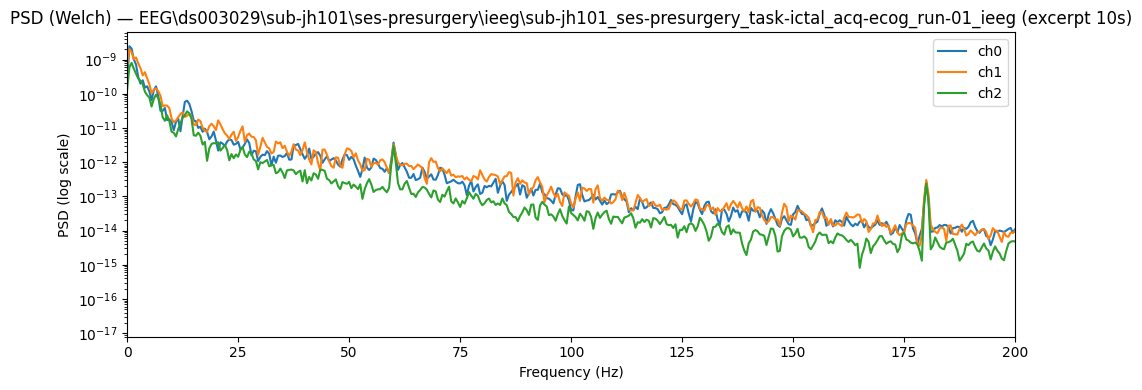

,base,picked_ch_idx,bp_delta,bp_theta,bp_alpha,bp_beta,bp_gamma,bp_hfo
0,EEG\ds003029\sub-jh101\ses-presurgery\ieeg\sub...,0,1.805165e-09,4.244051e-10,1.031379e-10,1.673963e-10,4.994654e-11,5.819220e-12
1,EEG\ds003029\sub-jh101\ses-presurgery\ieeg\sub...,1,2.450191e-09,6.465350e-10,1.431395e-10,1.721426e-10,6.766939e-11,8.163518e-12
2,EEG\ds003029\sub-jh101\ses-presurgery\ieeg\sub...,2,1.045470e-09,2.836446e-10,7.079342e-11,8.550245e-11,1.645572e-11,1.683073e-12


Interpretation prompt: check narrow peaks near 50/60 Hz and harmonics -> line noise candidate.


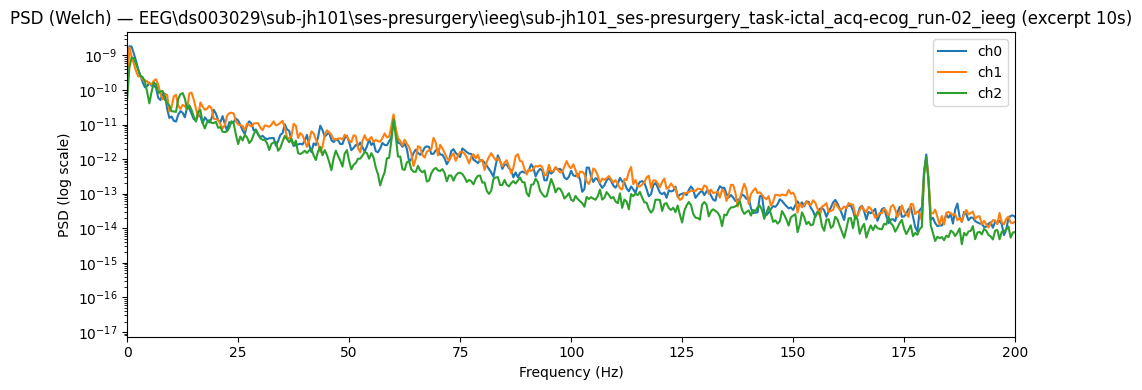

,base,picked_ch_idx,bp_delta,bp_theta,bp_alpha,bp_beta,bp_gamma,bp_hfo
0,EEG\ds003029\sub-jh101\ses-presurgery\ieeg\sub...,0,1.792555e-09,4.424669e-10,1.391144e-10,2.331445e-10,1.505137e-10,1.691540e-11
1,EEG\ds003029\sub-jh101\ses-presurgery\ieeg\sub...,1,1.092546e-09,6.020350e-10,2.410945e-10,3.832181e-10,2.083653e-10,2.335631e-11
2,EEG\ds003029\sub-jh101\ses-presurgery\ieeg\sub...,2,1.388626e-09,4.162845e-10,2.437271e-10,1.964060e-10,6.964086e-11,5.821311e-12


Interpretation prompt: check narrow peaks near 50/60 Hz and harmonics -> line noise candidate.


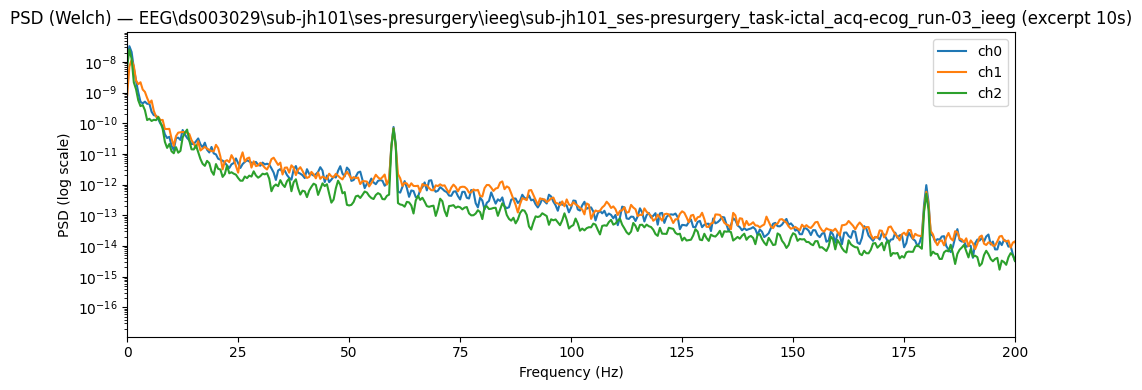

,base,picked_ch_idx,bp_delta,bp_theta,bp_alpha,bp_beta,bp_gamma,bp_hfo
0,EEG\ds003029\sub-jh101\ses-presurgery\ieeg\sub...,0,1.073475e-08,1.000465e-09,1.821492e-10,2.043287e-10,1.364922e-10,1.009696e-11
1,EEG\ds003029\sub-jh101\ses-presurgery\ieeg\sub...,1,1.078327e-08,1.492944e-09,2.643545e-10,2.281590e-10,1.413617e-10,1.511950e-11
2,EEG\ds003029\sub-jh101\ses-presurgery\ieeg\sub...,2,5.647775e-09,5.404558e-10,1.085738e-10,1.264096e-10,7.767862e-11,3.622271e-12


Interpretation prompt: check narrow peaks near 50/60 Hz and harmonics -> line noise candidate.


In [20]:
def bandpower_from_psd(freqs: np.ndarray, psd: np.ndarray, fmin: float, fmax: float) -> float:
    mask = (freqs >= fmin) & (freqs <= fmax)
    if not np.any(mask):
        return float('nan')
    return float(np.trapezoid(psd[mask], freqs[mask]))


BANDS = {
    'delta': (1, 4),
    'theta': (4, 8),
    'alpha': (8, 13),
    'beta':  (13, 30),
    'gamma': (30, 80),
    'hfo':   (80, 150),
}


if (mne is None) or (welch is None):
    print('Skip: need mne + scipy')
else:
    for _, row in deep_runs.iterrows():
        base = row['base']
        p = paths_from_base(DATASET_ROOT, base)
        if not Path(p['vhdr']).exists():
            continue

        onset = float(row.get('seizure_onset_s', np.nan))
        t0 = max(0.0, onset) if not np.isnan(onset) else 0.0

        raw = mne.io.read_raw_brainvision(str(p['vhdr']), preload=False, verbose='ERROR')
        fs = float(raw.info['sfreq'])
        raw_ex = raw.copy().crop(tmin=t0, tmax=min(raw.times[-1], t0 + EXCERPT_PSD_SEC))

        # Channel selection aligned with notebook cũ
        ch_df = read_tsv_if_exists(p['channels'])
        good_names = pick_good_ieeg_channels(ch_df, MAX_CHANNELS)
        if good_names:
            picks = mne.pick_channels(raw_ex.ch_names, include=good_names)
        else:
            picks = np.arange(min(MAX_CHANNELS, raw_ex.info['nchan']))

        picks = picks[:min(3, len(picks))]
        if len(picks) == 0:
            print('No channels picked for', base)
            continue

        x, _ = raw_ex[picks, :]

        fig, ax = plt.subplots(1, 1, figsize=(10, 4))
        bp_rows = []
        for i in range(x.shape[0]):
            freqs, psd = welch(x[i], fs=fs, nperseg=min(int(fs * 2), x.shape[1]))
            ax.semilogy(freqs, psd, label=f'ch{i}')
            row_bp = {'base': base, 'picked_ch_idx': int(picks[i])}
            for name, (fmin, fmax) in BANDS.items():
                row_bp[f'bp_{name}'] = bandpower_from_psd(freqs, psd, fmin, fmax)
            bp_rows.append(row_bp)

        ax.set_xlim(0, 200)
        ax.set_xlabel('Frequency (Hz)')
        ax.set_ylabel('PSD (log scale)')
        ax.set_title(f'PSD (Welch) — {base} (excerpt {EXCERPT_PSD_SEC}s)')
        ax.legend()
        plt.tight_layout()
        plt.show()

        bp_df = pd.DataFrame(bp_rows)
        display(bp_df)
        print('Interpretation prompt: check narrow peaks near 50/60 Hz and harmonics -> line noise candidate.')

### Conclusions to write (Section 4)
- If PSD shows narrow peaks at ~50/60 Hz (and harmonics), explicitly label them as **unwanted periodic noise**.
- Justify **notch filtering** or **frequency masking** before computing spectral features.
- Describe physiological bands separately, avoiding over-interpretation (EDA ≠ clinical diagnosis).

## 5) Temporal behavior and trend (Non-stationarity)

**EDA questions answered here:**
- Are feature statistics stable over time? (Usually: no.)
- Do features change around seizure onset/offset?

Here, **trend** means slow changes in summary statistics within a run (e.g., RMS drift), not calendar-based trends.

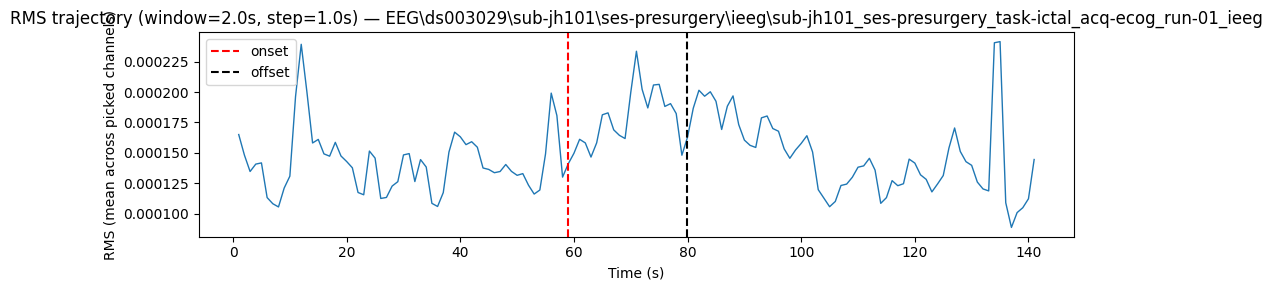

Interpretation prompt: non-stationarity is expected; look for systematic changes near onset/offset but avoid over-claiming.


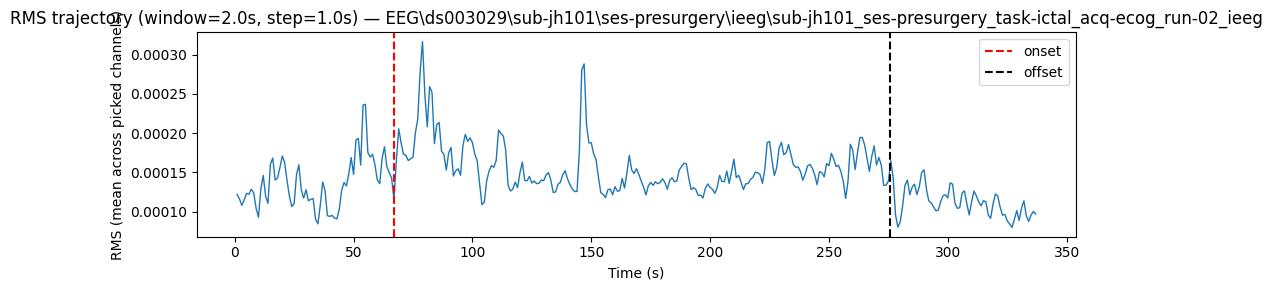

Interpretation prompt: non-stationarity is expected; look for systematic changes near onset/offset but avoid over-claiming.


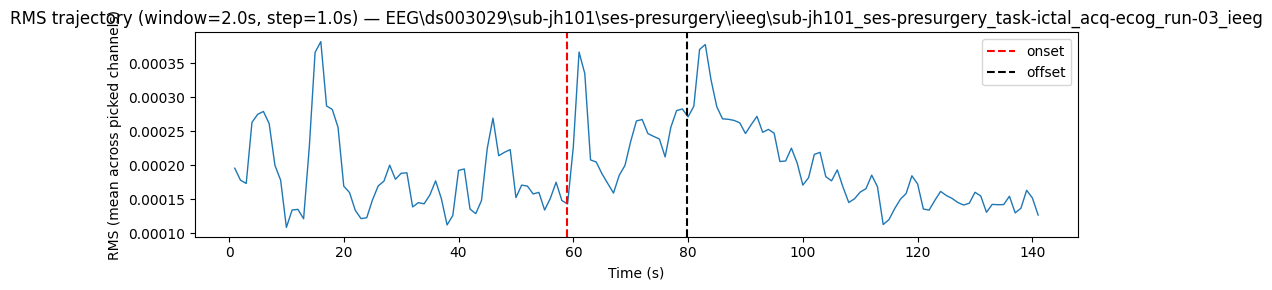

Interpretation prompt: non-stationarity is expected; look for systematic changes near onset/offset but avoid over-claiming.


In [21]:
def sliding_rms(x: np.ndarray, fs: float, win_sec: float, step_sec: float) -> tuple[np.ndarray, np.ndarray]:
    win = int(round(win_sec * fs))
    step = int(round(step_sec * fs))
    n = x.shape[1]
    starts = np.arange(0, max(1, n - win + 1), step, dtype=int)
    rms_vals = []
    t_mid = []
    for s in starts:
        seg = x[:, s:s + win]
        rms_vals.append(float(np.sqrt(np.mean(seg ** 2))))
        t_mid.append((s + win / 2) / fs)
    return np.array(t_mid), np.array(rms_vals)


if mne is None:
    print('Skip: mne not available')
else:
    for _, row in deep_runs.iterrows():
        base = row['base']
        p = paths_from_base(DATASET_ROOT, base)
        if not Path(p['vhdr']).exists():
            continue

        onset = float(row.get('seizure_onset_s', np.nan))
        offset = float(row.get('seizure_offset_s', np.nan))

        raw = mne.io.read_raw_brainvision(str(p['vhdr']), preload=False, verbose='ERROR')
        fs = float(raw.info['sfreq'])

        if (not np.isnan(onset)) and (not np.isnan(offset)):
            t0 = max(0.0, onset - PRE_SEC)
            t1 = min(raw.times[-1], offset + POST_SEC)
        else:
            t0 = 0.0
            t1 = min(raw.times[-1], 5 * 60.0)

        raw_seg = raw.copy().crop(tmin=t0, tmax=t1)

        # Channel selection aligned with notebook cũ
        ch_df = read_tsv_if_exists(p['channels'])
        good_names = pick_good_ieeg_channels(ch_df, MAX_CHANNELS)
        if good_names:
            picks = mne.pick_channels(raw_seg.ch_names, include=good_names)
        else:
            picks = np.arange(min(MAX_CHANNELS, raw_seg.info['nchan']))

        x, _ = raw_seg[picks, :]

        t_mid, rms_t = sliding_rms(x, fs, WINDOW_SEC, STEP_SEC)

        plt.figure(figsize=(10, 3))
        plt.plot(t_mid + t0, rms_t, lw=1)
        if not np.isnan(onset):
            plt.axvline(onset, color='r', ls='--', label='onset')
        if not np.isnan(offset):
            plt.axvline(offset, color='k', ls='--', label='offset')
        plt.title(f'RMS trajectory (window={WINDOW_SEC}s, step={STEP_SEC}s) — {base}')
        plt.xlabel('Time (s)')
        plt.ylabel('RMS (mean across picked channels)')
        plt.legend()
        plt.tight_layout()
        plt.show()

        print('Interpretation prompt: non-stationarity is expected; look for systematic changes near onset/offset but avoid over-claiming.')

### Conclusions to write (Section 5)
- Explicitly state: iEEG is **non-stationary**, so fixed global statistics are insufficient.
- Justify window-based EDA as a principled way to summarize local dynamics.
- If feature shifts cluster around onset/offset, interpret as *potential seizure-associated change*, not proof.

## 6) Spike and outlier analysis

**EDA questions answered here:**
- Are there transient high-energy windows?
- Do these spikes plausibly correspond to artifacts (motion, electrode pops, system noise)?
- How could spikes mimic seizure activity?

We use simple, explainable outlier scores on window features (RMS/PTP/line-length) and visualize where spikes occur in time.

Run EEG\ds003029\sub-jh101\ses-presurgery\ieeg\sub-jh101_ses-presurgery_task-ictal_acq-ecog_run-01_ieeg: outlier windows rate (score>=6.0): 2.84%


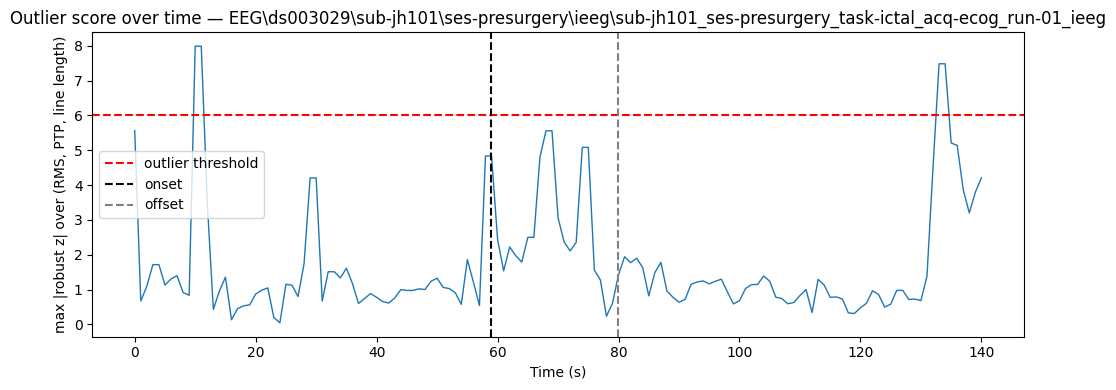

,t_start,t_end,rms,ptp,line_length,rms_rz,ptp_rz,line_length_rz,outlier_score,is_outlier
11,11.0,13.0,0.000239,0.004294,0.000004,3.260226,7.986398,3.369508,7.986398,1
10,10.0,12.0,0.000196,0.004294,0.000004,1.762660,7.986398,2.145445,7.986398,1
133,133.0,135.0,0.000241,0.004091,0.000005,3.304393,7.480843,6.812292,7.480843,1
134,134.0,136.0,0.000242,0.004091,0.000005,3.337045,7.480843,5.891671,7.480843,1
0,0.0,2.0,0.000165,0.003321,0.000003,0.675650,5.564006,1.057748,5.564006,0
69,69.0,71.0,0.000200,0.003318,0.000004,1.879006,5.557687,3.405323,5.557687,0
68,68.0,70.0,0.000162,0.003318,0.000005,0.561013,5.557687,4.653442,5.557687,0
135,135.0,137.0,0.000109,0.001085,0.000005,-1.277808,0.000000,5.208007,5.208007,0
136,136.0,138.0,0.000089,0.000459,0.000005,-1.985169,-1.558058,5.137908,5.137908,0
75,75.0,77.0,0.000188,0.003127,0.000004,1.480440,5.082007,1.753564,5.082007,0


Run EEG\ds003029\sub-jh101\ses-presurgery\ieeg\sub-jh101_ses-presurgery_task-ictal_acq-ecog_run-02_ieeg: outlier windows rate (score>=6.0): 2.97%


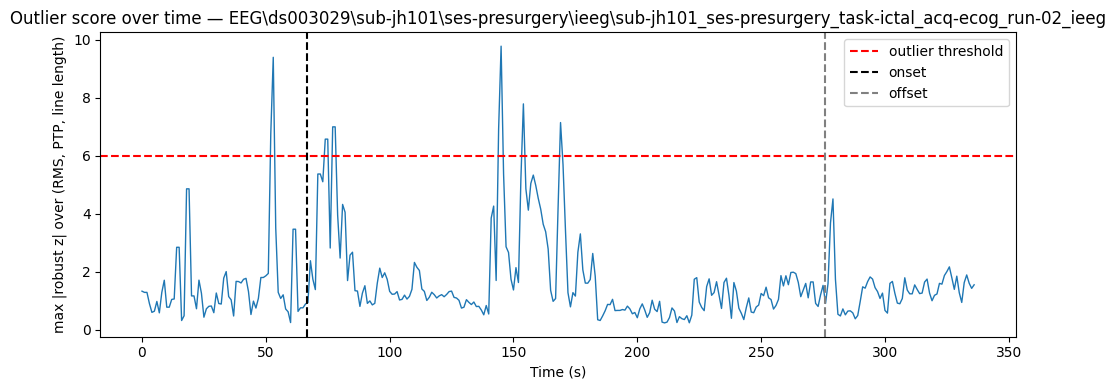

,t_start,t_end,rms,ptp,line_length,rms_rz,ptp_rz,line_length_rz,outlier_score,is_outlier
145,145.0,147.0,0.000280,0.002351,0.000009,5.093946,2.755858,9.786121,9.786121,1
53,53.0,55.0,0.000236,0.005022,0.000005,3.474649,9.401833,1.642797,9.401833,1
154,154.0,156.0,0.000122,0.001219,0.000008,-0.642947,-0.060988,7.793960,7.793960,1
169,169.0,171.0,0.000147,0.001217,0.000008,0.277350,-0.066090,7.149402,7.149402,1
77,77.0,79.0,0.000278,0.004057,0.000005,5.010021,7.000714,2.518221,7.000714,1
78,78.0,80.0,0.000316,0.004057,0.000005,6.397821,7.000714,1.704018,7.000714,1
144,144.0,146.0,0.000177,0.001576,0.000008,1.357010,0.828070,6.925420,6.925420,1
52,52.0,54.0,0.000159,0.003961,0.000004,0.705807,6.761377,0.667836,6.761377,1
74,74.0,76.0,0.000169,0.003887,0.000006,1.074041,6.576958,3.230373,6.576958,1
75,75.0,77.0,0.000200,0.003887,0.000005,2.187205,6.576958,2.405841,6.576958,1


Run EEG\ds003029\sub-jh101\ses-presurgery\ieeg\sub-jh101_ses-presurgery_task-ictal_acq-ecog_run-03_ieeg: outlier windows rate (score>=6.0): 2.13%


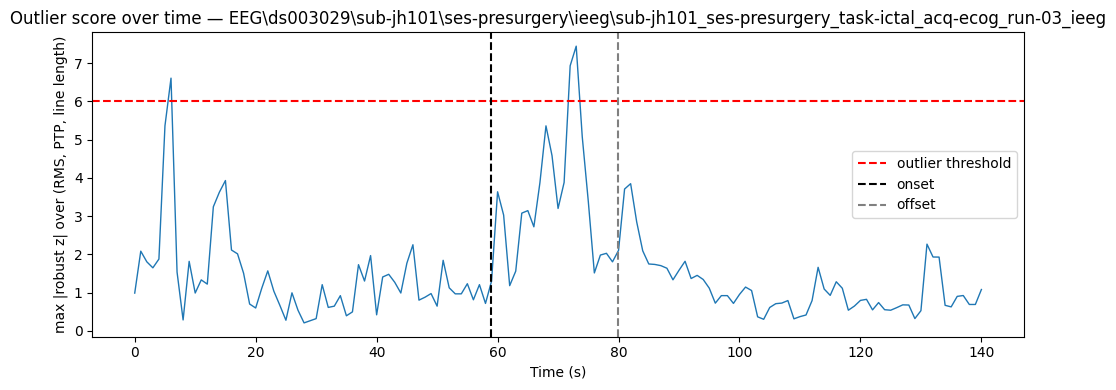

,t_start,t_end,rms,ptp,line_length,rms_rz,ptp_rz,line_length_rz,outlier_score,is_outlier
73,73.0,75.0,0.000242,0.002190,0.000006,1.255190,2.230880,7.444212,7.444212,1
72,72.0,74.0,0.000246,0.002190,0.000006,1.334347,2.230880,6.931558,6.931558,1
6,6.0,8.0,0.000261,0.003300,0.000006,1.615224,5.362651,6.608458,6.608458,1
5,5.0,7.0,0.000279,0.003300,0.000005,1.959554,5.362651,4.758239,5.362651,0
68,68.0,70.0,0.000200,0.001831,0.000006,0.434881,1.218722,5.361347,5.361347,0
74,74.0,76.0,0.000238,0.001638,0.000006,1.180760,0.674500,5.075173,5.075173,0
69,69.0,71.0,0.000235,0.001978,0.000005,1.113443,1.633775,4.583520,4.583520,0
15,15.0,17.0,0.000382,0.002430,0.000004,3.932053,2.907580,0.163486,3.932053,0
71,71.0,73.0,0.000267,0.001753,0.000005,1.732454,0.998094,3.881310,3.881310,0
67,67.0,69.0,0.000185,0.001733,0.000005,0.156282,0.942754,3.876096,3.876096,0


In [30]:
def line_length(x: np.ndarray) -> float:
    return float(np.mean(np.abs(np.diff(x, axis=1))))


def window_features(x: np.ndarray, fs: float, win_sec: float, step_sec: float) -> pd.DataFrame:
    win = int(round(win_sec * fs))
    step = int(round(step_sec * fs))
    n = x.shape[1]
    starts = np.arange(0, max(1, n - win + 1), step, dtype=int)
    rows = []
    for s in starts:
        seg = x[:, s:s + win]
        rms = float(np.sqrt(np.mean(seg ** 2)))
        ptp = float(np.ptp(seg))
        ll = line_length(seg)
        rows.append({
            't_start': s / fs,
            't_end': (s + win) / fs,
            'rms': rms,
            'ptp': ptp,
            'line_length': ll,
        })
    return pd.DataFrame(rows)


def add_outlier_scores(df: pd.DataFrame, cols: list[str]) -> pd.DataFrame:
    out = df.copy()
    for c in cols:
        z = robust_z(out[c].to_numpy())
        out[c + '_rz'] = z
    out['outlier_score'] = np.max(np.abs(out[[c + '_rz' for c in cols]].to_numpy()), axis=1)
    return out


if mne is None:
    print('Skip: mne not available')
else:
    for _, row in deep_runs.iterrows():
        base = row['base']
        p = paths_from_base(DATASET_ROOT, base)
        if not Path(p['vhdr']).exists():
            continue

        onset = float(row.get('seizure_onset_s', np.nan))
        offset = float(row.get('seizure_offset_s', np.nan))

        raw = mne.io.read_raw_brainvision(str(p['vhdr']), preload=False, verbose='ERROR')
        fs = float(raw.info['sfreq'])

        if (not np.isnan(onset)) and (not np.isnan(offset)):
            t0 = max(0.0, onset - PRE_SEC)
            t1 = min(raw.times[-1], offset + POST_SEC)
        else:
            t0 = 0.0
            t1 = min(raw.times[-1], 5 * 60.0)

        raw_seg = raw.copy().crop(tmin=t0, tmax=t1)

        # Channel selection aligned with notebook cũ
        ch_df = read_tsv_if_exists(p['channels'])
        good_names = pick_good_ieeg_channels(ch_df, MAX_CHANNELS)
        if good_names:
            picks = mne.pick_channels(raw_seg.ch_names, include=good_names)
        else:
            picks = np.arange(min(MAX_CHANNELS, raw_seg.info['nchan']))

        x, _ = raw_seg[picks, :]

        feat = window_features(x, fs, WINDOW_SEC, STEP_SEC)
        feat = add_outlier_scores(feat, ['rms', 'ptp', 'line_length'])

        # Mark extreme outliers (tunable; explain in report)
        thr = 6.0
        feat['is_outlier'] = (feat['outlier_score'] >= thr).astype(int)
        out_rate = float(feat['is_outlier'].mean())
        print(f'Run {base}: outlier windows rate (score>={thr}): {out_rate:.2%}')

        plt.figure(figsize=(10, 4))
        plt.plot(feat['t_start'] + t0, feat['outlier_score'], lw=1)
        plt.axhline(thr, color='r', ls='--', label='outlier threshold')
        if not np.isnan(onset):
            plt.axvline(onset, color='k', ls='--', label='onset')
        if not np.isnan(offset):
            plt.axvline(offset, color='gray', ls='--', label='offset')
        plt.title(f'Outlier score over time — {base}')
        #plt.title(f'Outlier score over time — sub-jh101/run-03')
        plt.xlabel('Time (s)')
        plt.ylabel('max |robust z| over (RMS, PTP, line length)')
        plt.legend()
        plt.tight_layout()
        plt.show()

        display(feat.sort_values('outlier_score', ascending=False).head(10))

### Conclusions to write (Section 6)
- Spikes/outliers can come from artifacts and may look seizure-like in energy features.
- Propose an explicit **rule-based QC**: drop windows exceeding robust thresholds, and/or drop channels flagged as outliers.
- State that outlier handling is a prerequisite before any modeling claims.

## 7) Sampling rate and heterogeneity issues

**EDA questions answered here:**
- How variable is sampling rate across runs?
- How does heterogeneity affect spectral feature comparability?

This is a dataset-level risk: differences in `sfreq` can confound PSD/bandpower features across runs.

Top sampling rates (value counts):


sfreq
1000.000000    72
999.412111     13
249.853552     10
499.707104      7
2000.000000     3
1024.599795     1
Name: count, dtype: int64

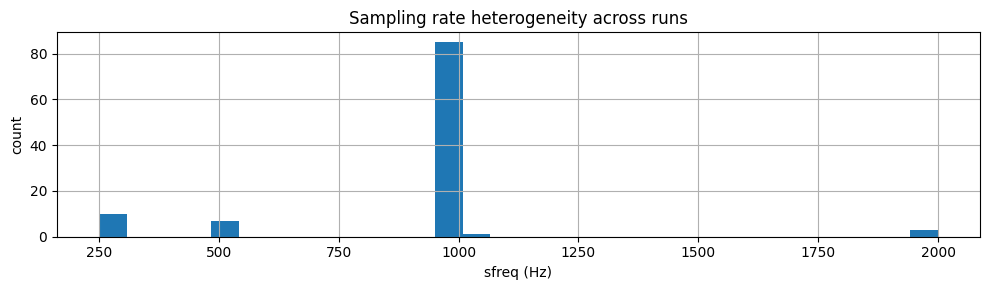

In [23]:
if 'sfreq' in run_summary.columns:
    vc = run_summary['sfreq'].round(6).value_counts(dropna=True).head(20)
    print('Top sampling rates (value counts):')
    display(vc)

    plt.figure(figsize=(10,3))
    run_summary['sfreq'].dropna().hist(bins=30)
    plt.title('Sampling rate heterogeneity across runs')
    plt.xlabel('sfreq (Hz)')
    plt.ylabel('count')
    plt.tight_layout()
    plt.show()
else:
    print('No sfreq column in run_summary')

### Conclusions to write (Section 7)
- If multiple sampling rates exist, state why resampling or feature normalization is necessary.
- Explain that PSD resolution and frequency binning depend on `sfreq`, impacting bandpower comparability.

## 8) Data leakage and evaluation risks

**EDA questions answered here:**
- Why is random window-level splitting invalid?
- What correlations exist within a subject/run that break IID assumptions?

This is a conceptual section: it should read like a methodology warning in a report.

### Leakage explanation (include in report)
- Windows from the same run share electrodes, noise profile, baseline amplitude, and patient-specific physiology.
- If train/test are split at the window level, the model can memorize run identity and yield inflated metrics.

**Justified future split strategy:**
- Prefer **subject-wise split** (best).
- If subject-wise is impossible due to small N, at least use **run-wise split** and report limitations.

## 9) Preprocessing recommendations (Final EDA conclusion)

This final section summarizes issues discovered and proposes a preprocessing roadmap.

**Required deliverable:** a clear statement of what the data is ready for (EDA, baseline prototyping) and what it is *not* ready for (generalizable modeling claims) given the current coverage.

### Preprocessing roadmap (copy into report)
1. **Data availability audit**: confirm which runs have signal content; document usable fraction.
2. **Label verification**: spot-check onset/offset vs raw events files.
3. **Channel QC**: remove flatline channels; remove extreme RMS/PTP outliers (robust thresholds).
4. **Amplitude normalization**: per-channel robust scaling or per-run normalization to reduce scale confounds.
5. **Line-noise handling**: notch 50/60 Hz (+ harmonics) or mask narrow frequency bands when extracting spectral features.
6. **Sampling rate standardization**: resample to a common `sfreq`, or use relative spectral features with careful validation.
7. **Window QC**: drop high outlier-score windows (artifact bursts).
8. **Split strategy** (future modeling): subject-wise or run-wise split to prevent leakage.

### Final conclusion template
- **Ready for:** exploratory feature engineering, sanity-check baselines on the *downloaded subset*, and methodological reporting.
- **Not ready for:** strong generalization claims across subjects/hospitals/acquisitions until signal coverage increases and preprocessing/QC are standardized.